# <hr style="clear: both" />

# Running Spark in YARN-client mode

This notebook demonstrates how to set up a SparkContext that uses SURFsara's Hadoop cluster: [YARN resourcemanager](http://head05.hathi.surfsara.nl:8088/cluster) (note you will need to be authenticated via kerberos on your machine to visit the resourcemanager link) for executors.

First initialize kerberos via a Jupyter terminal. 
In the terminal execute: <BR>
<i>kinit -k -t data/robertop.keytab robertop@CUA.SURFSARA.NL</i><BR>
Print your credentials:


In [1]:
! klist

Ticket cache: FILE:/tmp/krb5cc_1000
Default principal: robertop@CUA.SURFSARA.NL

Valid starting       Expires              Service principal
06/18/2016 07:22:44  06/19/2016 07:22:44  krbtgt/CUA.SURFSARA.NL@CUA.SURFSARA.NL
	renew until 06/18/2016 07:22:44


In [2]:
! hdfs dfs -ls 
execfile('../spark-scripts/bullet.py')

Found 5 items
drwx------   - robertop hdfs          0 2016-06-17 00:00 .Trash
drwxr-xr-x   - robertop hdfs          0 2016-06-18 07:40 .sparkStaging
drwx------   - robertop hdfs          0 2016-04-06 15:54 .staging
drwxr-xr-x   - robertop hdfs          0 2016-05-25 06:28 mattia
drwxr-xr-x   - robertop hdfs          0 2016-04-13 10:00 recsys2016Competition


Verify that we can browse HDFS:

Next initialize Spark. Note that the code below starts a job on the Hadoop cluster that will remain running while the notebook is active. Please close and halt the notebook when you are done. Starting the SparkContext can take a little longer. You can check the YARN resourcemanager to see the current status/usage of the cluster.

In [3]:
import os
os.environ['PYSPARK_PYTHON'] = '/usr/local/bin/python2.7'

HDFS_PATH = "hdfs://hathi-surfsara"

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sconf = SparkConf(False)

sconf.setAppName('Results')

# Master is now yarn-client. The YARN and hadoop config is read from the environment
sconf.setMaster("yarn-client")

# You can control many Spark settings via the SparkConf. This determines the amount of executors on the cluster:
sconf.set("spark.executor.instances", "10")
#sconf.set("spark.executor.memory", "10g")

# UFW (firewall) is active on the VM. We explicitly opened these ports and Spark should not bind to random ports:
sconf.set("spark.driver.port", 51800)
sconf.set("spark.fileserver.port", 51801)
sconf.set("spark.broadcast.port", 51802)
sconf.set("spark.replClassServer.port", 51803)
sconf.set("spark.blockManager.port", 51804)
sconf.set("spark.authenticate", True)
sconf.set("spark.yarn.keytab", "/home/jovyan/work/data/robertop.keytab")
sconf.set("spark.yarn.access.namenodes", HDFS_PATH + ":8020")

try:
    sc = SparkContext(conf=sconf)
    sqlCtx = SQLContext(sc) 
    sendNotificationToMattia("Spark Context", str(sc))
except Exception, err:
    sendNotificationToMattia("Fuck you!", str(err)) 
    print str(err)

# <hr style="clear: both" />

# Now you can run your code


# Load all the results

In [55]:
import json

DATA_PATH = '/home/jovyan/work/data/mattia/resultsNew'


metrics = ['recall@N', 'precision@N']

jaccards = ['jaccardBase61', 'jaccardBase751', 'jaccardBase9']
collaboratives = ['collaborative/min_j_25_avgShrink2_higherMean']
hybrids = ['hybrid/coll_J25_S2_jaccard9']


def extract_results(x):
    new_results = {}
    for i in x:
        evaluation = i['evaluation']
        N = evaluation['N']
        values = evaluation['value']
        new_results[N] = values
    return new_results


#Load original results
original_res = {}
for m in metrics:
    with open(os.path.join(DATA_PATH, 'original', m), 'r') as f:
        res = []
        for line in f.readlines() :
            res.append(json.loads(line))
    original_res[m] = extract_results(res)
    
mf_res = {}
for m in metrics:
    with open(os.path.join(DATA_PATH, 'MF_Sessions/factors100/iterations10', m), 'r') as f:
        res = []
        for line in f.readlines() :
            res.append(json.loads(line))
    mf_res[m] = extract_results(res)
    

    
#Load Flat Result
flat_res = {}
for algo in jaccards + collaboratives + hybrids:
    flat_res[algo] = {}
    
    for m in metrics:
        with open(os.path.join(DATA_PATH, algo + '_' + '#'.join(['7.5', '0.2', '0.7']), 'full/flat', m), 'r') as f:
            res = []
            for line in f.readlines() :
                res.append(json.loads(line))
        flat_res[algo][m] = extract_results(res)
 
  
#Load Ideal Results
ideal_res = {}
for algo in jaccards + collaboratives + hybrids:
    ideal_res[algo] = {}
    
    for m in metrics:
        with open(os.path.join(DATA_PATH, algo + '_' + '#'.join(['7.5', '0.2', '0.7']), 'full/ideal', m), 'r') as f:
            res = []
            for line in f.readlines() :
                res.append(json.loads(line))
        ideal_res[algo][m] = extract_results(res)

    
#Load Eval Results
eval_res = {}
for algo in jaccards + collaboratives + hybrids:
    eval_res[algo] = {}
    
    for m in metrics:
        with open(os.path.join(DATA_PATH, algo, 'eval/ideal', m), 'r') as f:
            res = []
            for line in f.readlines() :
                res.append(json.loads(line))
        eval_res[algo][m] = extract_results(res)

In [20]:
flat_res

{'collaborative/min_j_25_avgShrink2_higherMean': {'precision@N': {1: 0.060865700642867476,
   2: 0.06399563153289098,
   5: 0.06528997939792326,
   10: 0.048170962785345654,
   15: 0.03957413187625892,
   20: 0.0339338253026576,
   25: 0.02972486925605143,
   50: 0.018647428874602946,
   100: 0.01088192736217624},
  'recall@N': {1: 0.012894415704226175,
   2: 0.02711498487732533,
   5: 0.0691585019793771,
   10: 0.10205031938621793,
   15: 0.1257568635923067,
   20: 0.14377780762089382,
   25: 0.15743054663505893,
   50: 0.19752315112164703,
   100: 0.23053393551551388}},
 'jaccardBase61': {'precision@N': {1: 0.05150863702448133,
   2: 0.04978088761188168,
   5: 0.049470478395380726,
   10: 0.04048618144986254,
   15: 0.033613310273706745,
   20: 0.02920843927210589,
   25: 0.02593491397427152,
   50: 0.016988031502573536,
   100: 0.0102650019637431},
  'recall@N': {1: 0.010912119159669753,
   2: 0.021092189926780563,
   5: 0.05240167342029358,
   10: 0.08577008863405462,
   15: 0.1068

In [21]:
font_title = {'family': 'serif',
                   'weight': 'normal',
                   'verticalalignment': 'bottom',
                   'size': 20}  


font_labels = {'family': 'serif',
                   'weight': 'normal',
                   'size': 14}   

# Compare Performances Jaccard Flattening

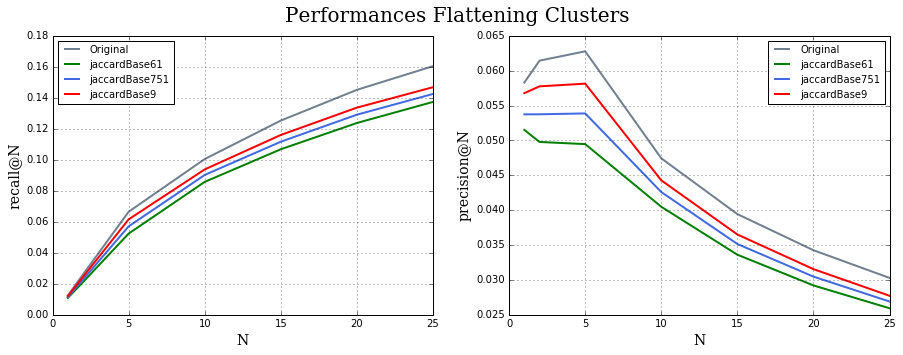

In [32]:
from matplotlib import pyplot as plt
%matplotlib inline

N = [1, 2, 5, 10, 15, 20, 25]

LINE_W = 2

#Compare Performances of Orginal VS Cluster Flat

plt.figure(1, figsize=(15,5))
plt.suptitle("Performances Flattening Clusters", fontdict = font_title, fontsize=16)

colors = ['green', 'royalblue', 'red', 'b', 'darkgreen', 'forestgreen']

for j,m in enumerate(metrics):
    plt.subplot(121+ j)
    
    original = [ original_res[m][i] for i in N ]
    plt.plot(N, original, 'slategrey', linewidth = LINE_W)
    
    for i,alg in enumerate(jaccards):
        clust_flat = [ flat_res[alg][m][k] for k in N ]
        
        plt.ylabel(m ,fontdict = font_labels)
        plt.xlabel('N', fontdict = font_labels)
        
        plt.plot(N, clust_flat, colors[i], linewidth = LINE_W)
        
    
    plt.legend(['Original'] + jaccards, fontsize = 10, loc=2 - j)
    plt.grid(True)
    
plt.show()


# Jaccard Effects on Training

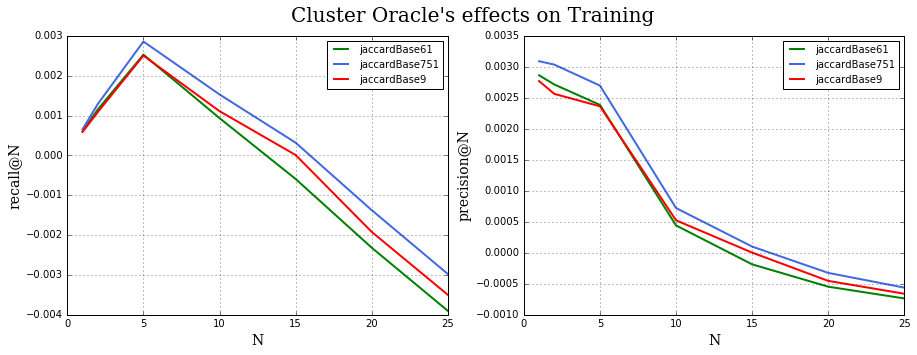

In [37]:
plt.figure(1, figsize=(15,5))
plt.suptitle("Cluster Oracle's effects on Training", fontdict = font_title, fontsize = 16)

colors = ['forestgreen','royalblue','crimson']
colors = ['green', 'royalblue', 'red', 'b', 'darkgreen', 'forestgreen']

for j,m in enumerate(metrics):
    
    plt.subplot(121 + j)
    plt.ylabel(m ,fontdict = font_labels)
    plt.xlabel('N', fontdict = font_labels)
    
    for i,alg in enumerate(jaccards):
        
        difference = [ideal_res[alg][m][k] - eval_res[alg][m][k] for k in N]        
        plt.plot(N, difference, colors[i], linewidth = LINE_W)    

    plt.legend(jaccards, fontsize = 10, loc=1)
    plt.grid(True)
    
plt.show()

# Uncertainty Jaccards

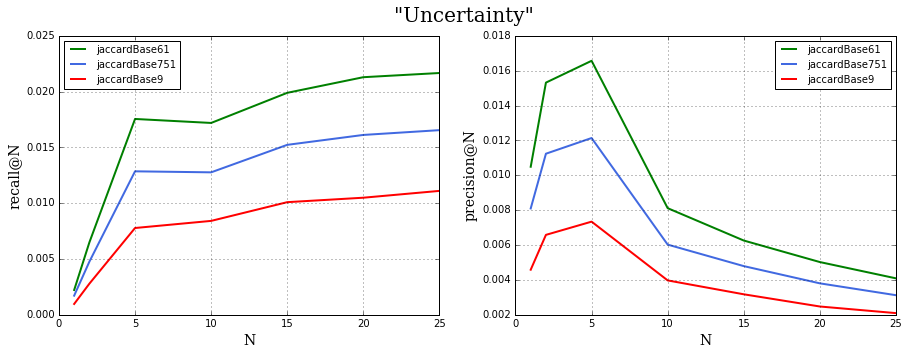

In [35]:
plt.figure(1, figsize=(15,5))
plt.suptitle('''"Uncertainty"''', fontdict = font_title, fontsize = 16)

colors = ['forestgreen','royalblue','crimson']
colors = ['green', 'royalblue', 'red', 'b', 'darkgreen', 'forestgreen']

for j,m in enumerate(metrics):
    
    plt.subplot(121 + j)
    plt.ylabel(m ,fontdict = font_labels)
    plt.xlabel('N', fontdict = font_labels)
    
    for i,alg in enumerate(jaccards):    
        difference = [ideal_res[alg][m][k] - flat_res[alg][m][k] for k in N]        
        plt.plot(N, difference, colors[i], linewidth = LINE_W)

    plt.legend(jaccards, fontsize = 10, loc=2 - j)
    plt.grid(True)
plt.show()

# Flattening Collaborative

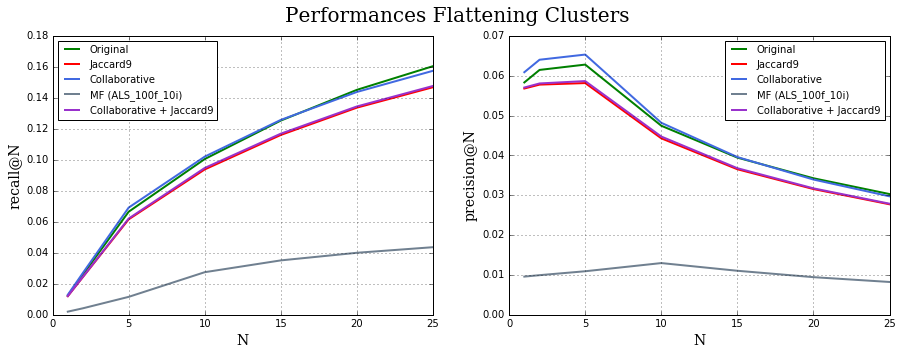

In [66]:

plt.figure(1, figsize=(15,5))
plt.suptitle("Performances Flattening Clusters", fontdict = font_title, fontsize=16)

colors = ['red', 'royalblue', 'green', 'b', 'darkgreen', 'forestgreen']

for j,m in enumerate(metrics):
    plt.subplot(121+ j)
    
    original = [ original_res[m][i] for i in N ]
    plt.plot(N, original, 'green', linewidth = LINE_W)
    
    jac = [ flat_res['jaccardBase9'][m][k] for k in N ]
    plt.plot(N, jac, colors[0], linewidth = LINE_W)
    
    coll = [ flat_res['collaborative/min_j_25_avgShrink2_higherMean'][m][k] for k in N ]
    plt.plot(N, coll, colors[1], linewidth = LINE_W)
    
    mf = [ mf_res[m][k] for k in N ]
    plt.plot(N, mf, 'slategrey', linewidth = LINE_W)
    
    hyb = [ flat_res[hybrids[0]][m][k] for k in N ]
    plt.plot(N, hyb,'darkorchid', linewidth = LINE_W)
    
        
    plt.ylabel(m ,fontdict = font_labels)
    plt.xlabel('N', fontdict = font_labels)
    
    plt.legend(['Original', 'Jaccard9', 'Collaborative', 'MF (ALS_100f_10i)', 'Collaborative + Jaccard9' ], fontsize = 10, loc=2 - j)
    plt.grid(True)
    
plt.show()


# Uncertainty

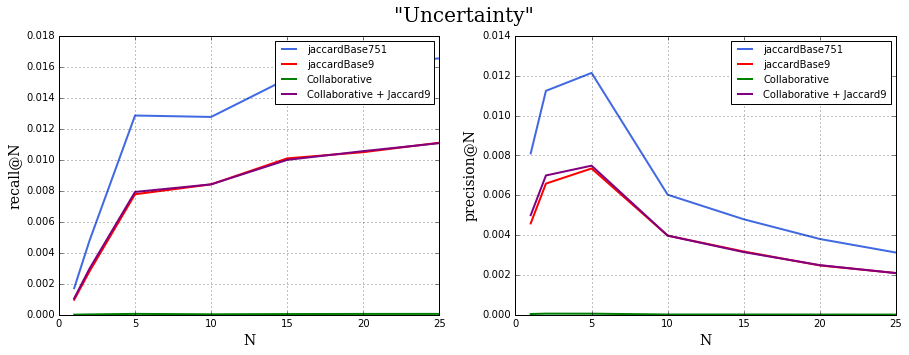

In [67]:
plt.figure(1, figsize=(15,5))
plt.suptitle('''"Uncertainty"''', fontdict = font_title, fontsize = 16)

colors = ['forestgreen','royalblue','crimson']
colors = ['royalblue', 'red', 'green', 'purple', 'darkgreen', 'forestgreen']


for j,m in enumerate(metrics):
    
    plt.subplot(121 + j)
    plt.ylabel(m ,fontdict = font_labels)
    plt.xlabel('N', fontdict = font_labels)
    
    for i,alg in enumerate(jaccards[1:]):    
        difference = [ideal_res[alg][m][k] - flat_res[alg][m][k] for k in N]        
        plt.plot(N, difference, colors[i], linewidth = LINE_W)
    
    difference = [ideal_res[collaboratives[0]][m][k] - flat_res[collaboratives[0]][m][k] for k in N]        
    plt.plot(N, difference, colors[i+1], linewidth = LINE_W)
    
    difference = [ideal_res[hybrids[0]][m][k] - flat_res[hybrids[0]][m][k] for k in N]        
    plt.plot(N, difference, colors[i+2], linewidth = LINE_W)

    plt.legend(jaccards[1:] + ['Collaborative', 'Collaborative + Jaccard9'], fontsize = 10, loc=1)
    plt.grid(True)
plt.show()

# Effects on Training

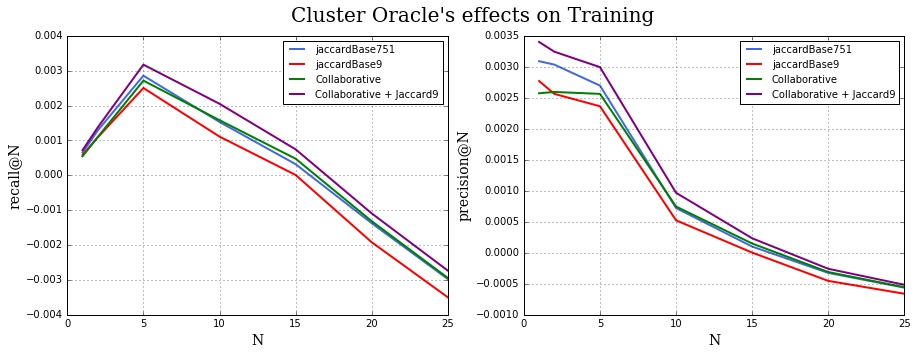

In [68]:
plt.figure(1, figsize=(15,5))
plt.suptitle("Cluster Oracle's effects on Training", fontdict = font_title, fontsize = 16)

colors = ['forestgreen','royalblue','crimson']
colors = ['royalblue', 'red', 'green', 'purple', 'darkgreen', 'forestgreen']

for j,m in enumerate(metrics):
    
    plt.subplot(121 + j)
    plt.ylabel(m ,fontdict = font_labels)
    plt.xlabel('N', fontdict = font_labels)
    
    for i,alg in enumerate(jaccards[1:]):
        difference = [ideal_res[alg][m][k] - eval_res[alg][m][k] for k in N]        
        plt.plot(N, difference, colors[i], linewidth = LINE_W)
    
    difference = [ideal_res[collaboratives[0]][m][k] - eval_res[collaboratives[0]][m][k] for k in N]        
    plt.plot(N, difference, colors[i+1], linewidth = LINE_W)
    
    difference = [ideal_res[hybrids[0]][m][k] - eval_res[hybrids[0]][m][k] for k in N]        
    plt.plot(N, difference, colors[i+2], linewidth = LINE_W)

    plt.legend(jaccards[1:] + ['Collaborative', 'Collaborative + Jaccard9'], fontsize = 10, loc=1)
    plt.grid(True)
    
plt.show()

# General Comparison

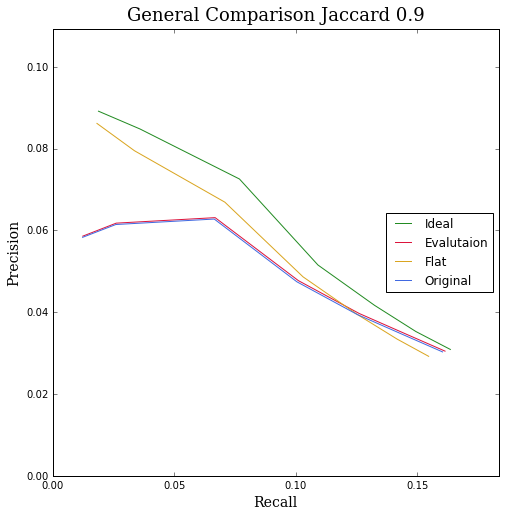

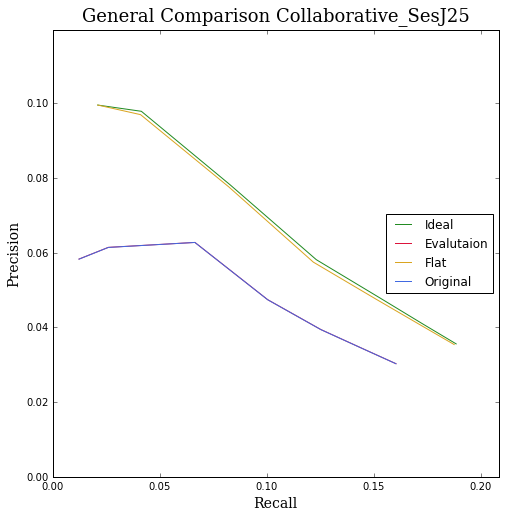

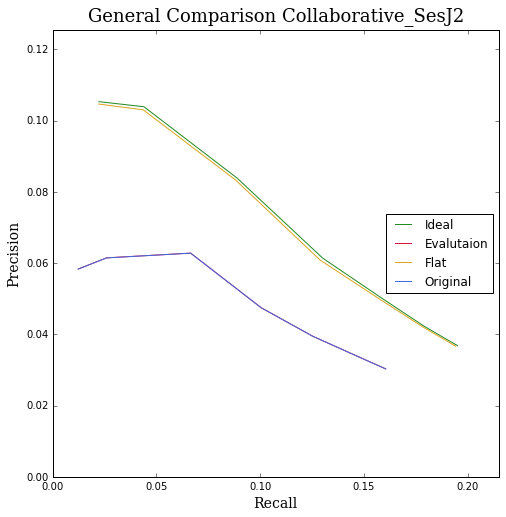

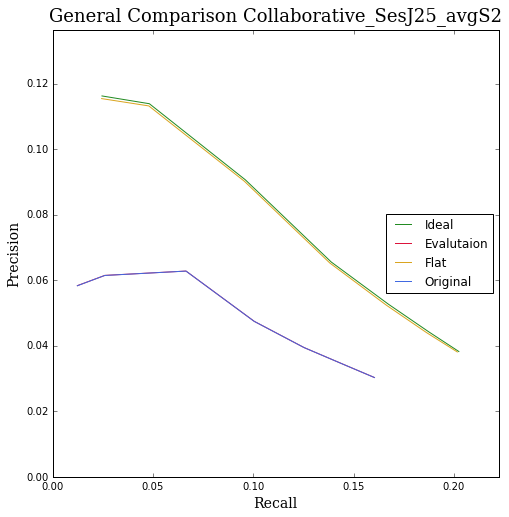

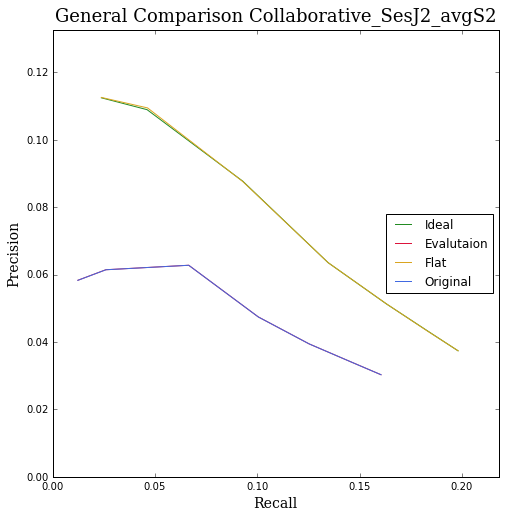

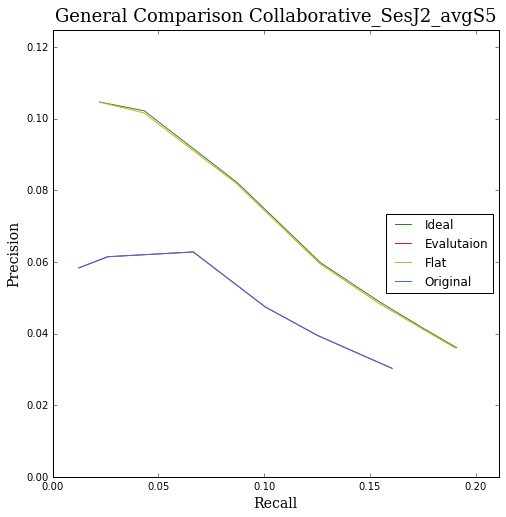

In [27]:
original_result = results['original']

for i,alg in enumerate(cluster_algos):
    full_ideal_results = results[alg]['full']['ideal']
    eval_ideal_results = results[alg]['eval']['ideal']
    flat_results = results[alg]['full']['flat']
    
    plt.figure(1+i, figsize=(8,8))
    plt.title("General Comparison " + algo_names[i+1], fontdict = font_title, fontsize= 18)
    plt.ylabel('Precision' ,fontdict = font_labels)
    plt.xlabel('Recall', fontdict = font_labels)
    
    
    original = {'Precision': [ extract_results(original_result['precision@N'])[i] for i in N ],
                'Recall' : [ extract_results(original_result['recall@N'])[i] for i in N ]}
        
    full_ideal = {'Precision': [ extract_results(full_ideal_results['precision@N'])[i] for i in N ],
                'Recall' : [ extract_results(full_ideal_results['recall@N'])[i] for i in N ]}
        
    flat = {'Precision': [ extract_results(flat_results['precision@N'])[i] for i in N ],
            'Recall' : [ extract_results(flat_results['recall@N'])[i] for i in N ]}
        
    eval_ideal = {'Precision': [ extract_results(eval_ideal_results['precision@N'])[i] for i in N ],
                  'Recall' : [ extract_results(eval_ideal_results['recall@N'])[i] for i in N ]}
    
    plt.axis([0, max(full_ideal['Recall']) + 0.02, 0, max(full_ideal['Precision']) + 0.02])
         
    
    plt.plot(full_ideal['Recall'], full_ideal['Precision'], 'forestgreen', linewidth = LINE_W)
    plt.plot(eval_ideal['Recall'], eval_ideal['Precision'], 'crimson', linewidth = LINE_W)
    
    plt.plot(flat['Recall'], flat['Precision'], 'goldenrod', linewidth = LINE_W)
    plt.plot(original['Recall'] , original['Precision'], 'royalblue', linewidth = LINE_W)
        
    plt.legend(['Ideal', 'Evalutaion', 'Flat', 'Original'], fontsize = 12, loc=7)
    plt.show()